# Figures for Raw Count of ICD-9 & CPT 

In [1]:
import os, sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import glob 
import pickle 


from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:90% !important; }</style>"))
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

DATE = datetime.now().strftime('%Y-%m-%d')

In [2]:
sys.path.append('/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification')
from hyperparam_tune import validate_best_model
from collections import OrderedDict 
from cycler import cycler
import time as time 

In [3]:
%load_ext rpy2.ipython

In [4]:
ROOT_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019-01-16_xgboost_hyperopt_icd_cpt_raw_counts" 
OUTPUT_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/counts_icd_cpt"
ICD_CPT_DESCRIP_FILE ="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/data/ptb_predict_machine_learning/icd_cpt_descrip_mapping/descrip_master-col_names.txt"

# Functions

In [5]:
def get_train_test_arrays(input_data):
    held_out_df = input_data.loc[input_data['partition']=='held_out'].copy()
    train_df = input_data.loc[input_data['partition']=='grid_cv'].copy()
    held_out_df.set_index('GRID',inplace=True)
    train_df.set_index('GRID',inplace=True)
    
    binarize = lambda x: 1 if x == 'preterm' else 0
    
    X_train = train_df.iloc[:,:-2]
    y_train = train_df.label.apply(binarize).values
    X_test = held_out_df.iloc[:,:-2]
    y_test = held_out_df.label.apply(binarize).values

    
    return X_train, y_train, X_test, y_test   

In [6]:
def unpack_input_data(input_file, model_file):
    '''load input file and split into training, and testing data '''
    
    input_data = pd.read_csv(input_file, sep="\t")
    print("done loading {}".format(os.path.basename(input_file)))

    X_train, y_train, X_test, y_test = get_train_test_arrays(input_data)    
    xgb_model = pickle.load(open(model_file, "rb"))
    
    return  X_train, y_train, X_test, y_test, xgb_model, input_data 

In [7]:
def plot_roc(store_fpr, store_tpr, aucs, plt_prefix='', roc_fig_file=None):
    '''
    plot auroc curve(s) with mean and std; save if a roc_fig_file is provided

        INPUTS:
            * store_fpr, store_tpr, aucs: a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * roc_fig_file: full path to save file
            * savefig: boolean to save or not save figure

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating roc plot.....")

    interp_fpr = np.linspace(0, 1, 100)
    store_tpr_interp = []

    ax = plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r', label='Chance', alpha=.8)

    # plot each cv iteration
    for cv_iter, fpr_tpr_auc in enumerate(zip(store_fpr, store_tpr, aucs)):
        # set_trace()
        fpr, tpr, auc = fpr_tpr_auc
        plt.plot(fpr, tpr, lw=4, alpha=0.9, label="#{}(AUC={:.3f})".format(cv_iter, auc))

        lin_fx = interp1d(fpr, tpr, kind='linear')
        interp_tpr = lin_fx(interp_fpr)

        # store_tpr_interp.append(np.interp(mean_fpr, fpr, tpr))
        # store_tpr_interp[-1][0] = 0.0
        store_tpr_interp.append(interp_tpr)

    # plot mean and std only if more than one curve present
    if len(store_fpr) != 1:
        # plot mean, sd, and shade in between
        mean_tpr = np.mean(store_tpr_interp, axis=0)
        # mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(interp_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(interp_fpr, mean_tpr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(store_tpr_interp, axis=0)
        tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
        plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if roc_fig_file:
        plt.savefig(roc_fig_file)
        print("\tDone. AUROC curve saved to:\n\t{}".format(roc_fig_file))

    return ax

In [8]:
def plot_pr(precisions, recalls, avg_prs, plt_prefix, pr_fig_file=None, pos_prop=None):
    ''' plot PR curve(s) with mean and std; save if pr_fig_file is provided

        INPUTS:
            * precisions, recalls, avg_prs: must be a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * pr_fig_file: full path to save file
            * pos_prop: total true positives / total samples (i.e. proportion of positves)

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating PR curve plot ...")
    # mean_rc = np.linspace(0, 1, 100)
    interp_rc = np.linspace(0, 1, 100)

    store_pr_interp = []
    ax = plt.figure()

    # plot line of random chance
    if pos_prop:
        plt.plot([0, 1], [pos_prop, pos_prop], linestyle='--', lw=4,
                 color='r', label='Chance({:.3f})'.format(pos_prop), alpha=.8)

    # plot each cv_iter
    for cv_iter, pr_rc_avg in enumerate(zip(precisions, recalls, avg_prs)):

        pr_array, rc_array, pr_avg = pr_rc_avg
        # plt.plot(rc_array, pr_array, lw=1, color='k', alpha=0.4)
        plt.step(rc_array, pr_array, lw=4, alpha=0.8, where='post', label="#{}(AvgPR={:.3f})".format(cv_iter, pr_avg))

        # interpolate recall to have the same length array for taking mean
        lin_fx = interp1d(rc_array, pr_array, kind='linear')
        interp_pr = lin_fx(interp_rc)
        store_pr_interp.append(interp_pr)

    # set_trace()

    # plot mean and std only if more than one curve present
    if len(precisions) != 1:
        # mean and std
        mean_pr = np.mean(store_pr_interp, axis=0)
        mean_avg_pr = np.mean(avg_prs)
        std_avg_pr = np.std(avg_prs)

        # std of each pr-curve
        std_pr = np.std(store_pr_interp, axis=0)
        pr_upper = np.minimum(mean_pr + 2*std_pr, 1)
        pr_lower = np.maximum(mean_pr - 2*std_pr, 0)
        plt.fill_between(interp_rc, pr_lower, pr_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

        plt.plot(interp_rc, mean_pr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_avg_pr, std_avg_pr), lw=2, alpha=0.8)

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if pr_fig_file:
        plt.savefig(pr_fig_file)
        print("\tPR curve saved to:\n\t{}".format(pr_fig_file))

    return ax

In [9]:
def create_descrip_dictionary(desrip_file): 
    
    dsc_df = pd.read_csv(ICD_CPT_DESCRIP_FILE,sep="\t")
    
    dsc_df['good_map'] = ~(dsc_df['feature'] == dsc_df['short_desc'])
    dsc_df['mod_desc'] = dsc_df['feature'] + "-"+  dsc_df['short_desc'] 
    
    # remove [, ] or <
    dsc_df.mod_desc = dsc_df.mod_desc.str.replace("[", "-")
    dsc_df.mod_desc = dsc_df.mod_desc.str.replace("]","-")
    dsc_df.mod_desc = dsc_df.mod_desc.str.replace("<","-")


    desc_dict = dict(zip(dsc_df.feature, dsc_df.mod_desc))
    
    return desc_dict

# Load and Format Raw Counts ICD & CPT 

## Load Data 

In [10]:
# INPUT  FILES 
icd_input = os.path.join(ROOT_DATA_DIR, 'input_data', 'input_data_all_icd9_count_subset-2019-01-25.tsv')
cpt_input = os.path.join(ROOT_DATA_DIR, 'input_data','input_data_all_cpt_count_subset-2019-01-26.tsv')
icd_cpt_input = os.path.join(ROOT_DATA_DIR, 'input_data','input_data_all_icd9_cpt_count_subset-2019-01-26.tsv')
# MODEL FILES 
icd_model = os.path.join(ROOT_DATA_DIR, 'best_model','best_xgb_model_all_icd9_count_subset-2019-01-25.pickle')
cpt_model = os.path.join(ROOT_DATA_DIR, 'best_model', 'best_xgb_model_all_cpt_count_subset-2019-01-26.pickle')
icd_cpt_model = os.path.join(ROOT_DATA_DIR, 'best_model', 'best_xgb_model_all_icd9_cpt_count_subset-2019-01-26.pickle')
# FEATURE IMPORTANCE FILES 
icd_feats = os.path.join(ROOT_DATA_DIR, 'feature_importance', 'w_descrip','descrip__-feature_importance_all_icd9_count_subset-2019-01-25.tsv')
cpt_feats = os.path.join(ROOT_DATA_DIR, 'feature_importance', 'w_descrip','descrip__-feature_importance_all_cpt_count_subset-2019-01-26.tsv')
icd_cpt_feats = os.path.join(ROOT_DATA_DIR, 'feature_importance', 'w_descrip','descrip__-feature_importance_all_icd9_cpt_count_subset-2019-01-26.tsv')

In [11]:
dataset_dict = OrderedDict()
dataset_dict['icd'] =  {'input_file': icd_input, 'model_file': icd_model, 'feat_file': icd_feats}
dataset_dict['cpt'] =   {'input_file': cpt_input, 'model_file': cpt_model, 'feat_file': cpt_feats}
dataset_dict['icd_cpt'] = {'input_file': icd_cpt_input, 'model_file': icd_cpt_model, 'feat_file': icd_cpt_feats} 

In [15]:
# output dictionary path with required data....
DATE = "2019-04-01"
STORED_DATA_FILE = os.path.join(OUTPUT_DIR,'{}_icd_cpt_datasets_dict.pickle'.format(DATE))

In [16]:
# load data if already saved; else run models and compile results  
if os.path.isfile(STORED_DATA_FILE):     
    print("loading pickled file...")
    metrics_file = open(STORED_DATA_FILE, 'rb')
    dataset_dict = pickle.load(metrics_file)

else: 
    print("compiling data...")
    store_results = {}
    for label, inner_dict in dataset_dict.items():
        sstart = time.time()
        print(label)
        
        X_train, y_train, X_test, y_test, xgb_model, input_data = unpack_input_data(inner_dict['input_file'], inner_dict['model_file'])
        metrics_results, metrics_df, model_params = validate_best_model(xgb_model, X_test, y_test)
        
        feat_df = pd.read_csv(inner_dict['feat_file'], sep="\t")

        dataset_dict[label]['metrics_df'] = metrics_df
        dataset_dict[label]['metrics_results'] = metrics_results
        dataset_dict[label]['input_df'] = input_data 
        dataset_dict[label]['xgb_model'] = xgb_model 
        dataset_dict[label]['feat_df'] = feat_df
        print("Finished {} in {:.2} mins".format(label, (time.time()-sstart)/60 ))

    pickle.dump(dataset_dict, open(STORED_DATA_FILE, 'wb'))    
    print("saved to...{}".format(OUTPUT_DIR))

loading pickled file...


### load metrics summary

In [ ]:
# append all the evaluation metrics into on df 
all_metrics_df = pd.DataFrame()
for label, inner_dict in dataset_dict.items(): 
    
    print(label)
    metrics_df = inner_dict['metrics_df']
#     metrics_df.head()
    metrics_df['dataset'] = label
    all_metrics_df = all_metrics_df.append(metrics_df)

In [ ]:
# all_metrics_df.head()
all_metrics_df.dataset = all_metrics_df.dataset.apply(lambda x: x.upper().replace("_", "+"))

In [ ]:
all_metrics_df.head()

# Figures

In [32]:
sns.set( style='whitegrid',  font_scale=1.5, rc={'figure.figsize':(8,8)} )
sns.set_style( {'axes.grid': True, 'axes.edgecolor': 'k', 'font.sans-serif': ['Arial'], 'grid.color': '#e1e1e1'})
plt.rc('axes', prop_cycle=(cycler('color', ['#1b9e77', '#d95f02', '#7570b3']) + cycler('linestyle', [':', ':', '-'])))
fsize=20
leg_fsize=14

##  ROC AUC

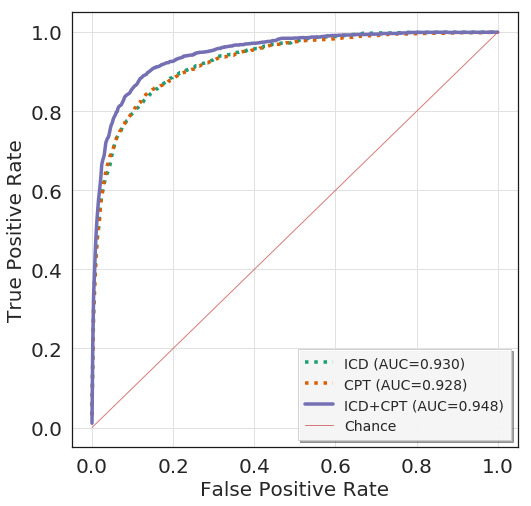

In [26]:
# ROC
interp_fpr = np.linspace(0, 1, 500)

fig = plt.figure()
for label, inner_dict in dataset_dict.items(): 
    metrics_results = inner_dict['metrics_results']
    fpr = metrics_results['fpr']
    tpr = metrics_results['tpr']
    auc = metrics_results['roc_auc']
    
    lin_fx = interp1d(fpr, tpr, kind='linear')
    interp_tpr = lin_fx(interp_fpr)
    _ = plt.plot(interp_fpr, interp_tpr, lw=3.5, alpha=1,
                 label="{} (AUC={:.3f})".format(label.upper().replace("_","+"), auc))


_ = plt.plot([0, 1], [0, 1], linestyle='-', lw=1, color='#CD5C5C', label='Chance', alpha=.8)    
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('False Positive Rate', fontsize=fsize)
_ = plt.ylabel('True Positive Rate', fontsize=fsize)
_ = plt.legend(loc="lower right", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)
_ = plt.tick_params(axis='both', which='major', labelsize=fsize)
# ax = fig.get_axes()[0]
# ax.tick_params(axis='y', size=200)


roc_fig_file = os.path.join(OUTPUT_DIR, '{}-roc_auc-icd_cpt.pdf'.format(DATE))
# plt.savefig(roc_fig_file)

## PR AUC 

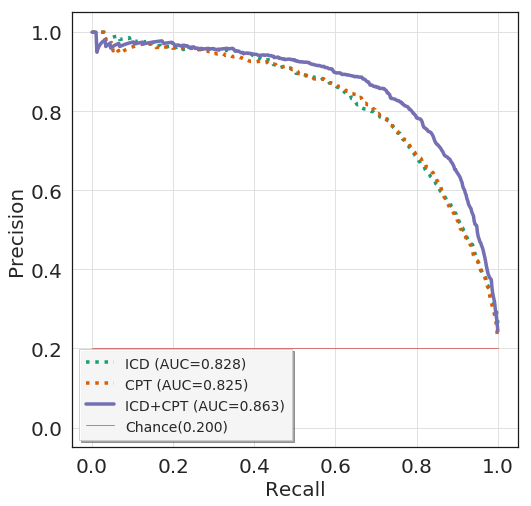

In [27]:
# PR 
interp_rc = np.linspace(0, 1, 500)

fig = plt.figure()
for label, inner_dict in dataset_dict.items(): 
    metrics_results = inner_dict['metrics_results']
    pr = metrics_results['pr_curve']
    rc = metrics_results['rc_curve']
    pr_auc = metrics_results['avg_prec']
    pos_prop=0.2
    
    lin_fx = interp1d(rc, pr, kind='linear')
    interp_pr = lin_fx(interp_rc)
    _ = plt.plot(interp_rc, interp_pr, lw=3.5, alpha=1,
                 label="{} (AUC={:.3f})".format(label.upper().replace("_","+"), pr_auc))

_ = plt.plot([0, 1], [pos_prop, pos_prop], linestyle='-', lw=1,
                 color='#CD5C5C', label='Chance({:.3f})'.format(pos_prop), alpha=.8)

_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('Recall', fontsize=fsize)
_ = plt.ylabel('Precision', fontsize=fsize)
_ = plt.legend(loc="lower left", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)
_ = plt.tick_params(axis='both', which='major', labelsize=fsize)
# ax = fig.get_axes()[0]
# ax.tick_params(axis='y', size=200)


pr_fig_file = os.path.join(OUTPUT_DIR, '{}-pr_auc-icd_cpt.pdf'.format(DATE))
# plt.savefig(pr_fig_file)

## F1, PR, and Recall 

In [28]:
# melt dataframe
melted_metrics_df = pd.melt(all_metrics_df, id_vars=['dataset'], value_vars=['precision','recall','f1'] )
melted_metrics_df.variable = melted_metrics_df.variable.str.upper()
melted_metrics_df.head(10)

,dataset,variable,value
0,ICD,PRECISION,0.682566
1,CPT,PRECISION,0.728710
2,ICD+CPT,PRECISION,0.790312
3,ICD,RECALL,0.800643
4,CPT,RECALL,0.770418
5,ICD+CPT,RECALL,0.797428
6,ICD,F1,0.736904
7,CPT,F1,0.748984
8,ICD+CPT,F1,0.793854


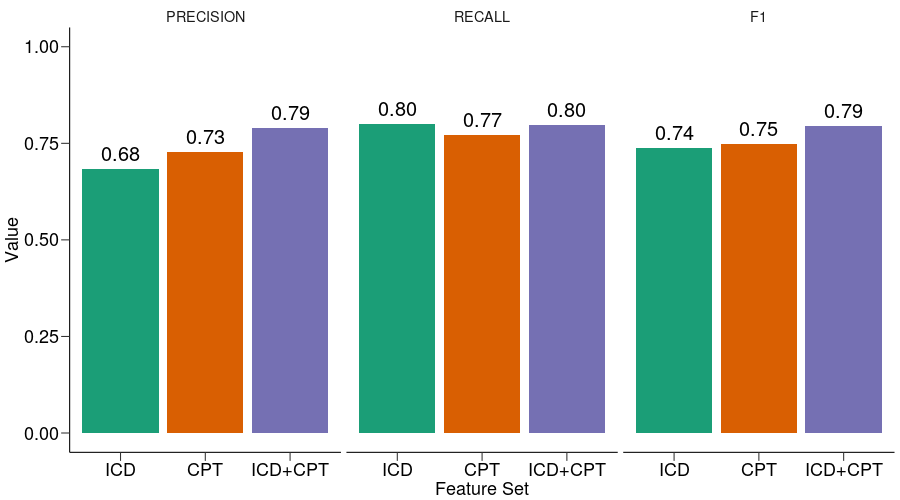

In [179]:
%%R -i melted_metrics_df  -h 500 -w 900
### PLOT ALL DATA POINTS 
library(ggplot2)

melted_metrics_df$dataset <-factor(melted_metrics_df$dataset, levels = c("ICD","CPT","ICD+CPT"))


melted_metrics_df$variable <-factor(melted_metrics_df$variable, 
                                levels = c("PRECISION",'RECALL','F1'))

mplt = ggplot(data = melted_metrics_df, aes(x=dataset, y=value, fill=dataset,
                                          label=sprintf("%0.2f", round(value, digits = 2)))) 
mplt = mplt + geom_text(aes(y = value + 0.04), size = 7) 
        theme(axis.text.x = element_text(angle = 315, hjust = 0))

mplt = mplt + facet_grid(~variable)
mplt = mplt + geom_bar(stat="identity")
mplt = mplt + scale_fill_manual(values=c('#1b9e77', '#d95f02', '#7570b3'))
mplt = mplt + xlab("Feature Set")
mplt = mplt + ylab("Value")
mplt = mplt + ylim(c(0,1))

mplt + theme_classic() + theme(
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
    legend.position="none",
    strip.background = element_rect(colour="white", fill="white"))

## Brier Score  Plot

In [42]:
%%R
# install.packages('extrafont')
library(extrafont)
font_import()
loadfonts(device="pdf")

Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n] n


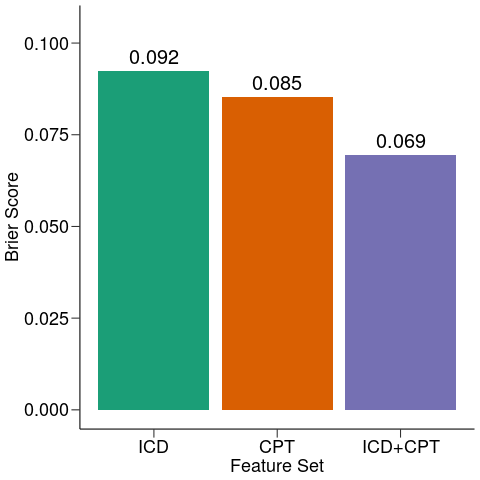

In [74]:
%%R  -i all_metrics_df -i OUTPUT_DIR -i DATE
library(ggplot2)

# order labels 
all_metrics_df$dataset <-factor(all_metrics_df$dataset, levels = c("ICD","CPT","ICD+CPT"))

barplt = ggplot(data = all_metrics_df, 
                aes(x=dataset, y=brier_score, fill=dataset,
                label=sprintf("%0.3f", round(brier_score, digits = 3)))) 

barplt = barplt + geom_bar(stat="identity")
barplt =barplt + geom_text(aes(y = brier_score + 0.004),size = 7, position = position_dodge(0.9)) +
        theme(axis.text.x = element_text(angle = 315, hjust = 0))

# figure params
barplt = barplt + scale_fill_manual(values= c('#1b9e77', '#d95f02', '#7570b3'))
barplt = barplt + xlab("Feature Set")
barplt = barplt + ylab("Brier Score")
barplt = barplt + ylim(c(0,0.105))

barplt = barplt + theme_classic() + theme(
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
    legend.position="none")

barplt
# pr_fig_file =  sprintf('%s-brier-icd_cpt.pdf',DATE)
# ggsave(pr_fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

## Feature Importance 

In [29]:
# load all feature importances into one data set 
feature_df = pd.DataFrame()
for label in ['icd','cpt','icd_cpt']:
    
    # load the top 10 features 
    fdf = dataset_dict[label]['feat_df'].iloc[:10,:].copy()
    fdf['dataset'] = label 
    
    feature_df = feature_df.append(fdf)

In [30]:
feature_df['description'] = feature_df.feature + " " + feature_df.short_desc.apply(lambda x: x[:25])

In [31]:
feature_df.head()

,feature,importance,short_desc,major,dataset,description
0,656.71,0.021942,Oth placent cond-deliver,Other known or suspected fetal and placental p...,icd,656.71 Oth placent cond-deliver
1,644.13,0.020645,Threat labor NEC-antepar,Early or threatened labor,icd,644.13 Threat labor NEC-antepar
2,658.21,0.015274,Prolong rupt memb-deliv,Other problems associated with amniotic cavity...,icd,658.21 Prolong rupt memb-deliv
3,658.23,0.012893,Prolong rup memb-antepar,Other problems associated with amniotic cavity...,icd,658.23 Prolong rup memb-antepar
4,651.01,0.012374,Twin pregnancy-delivered,Multiple gestation,icd,651.01 Twin pregnancy-delivered


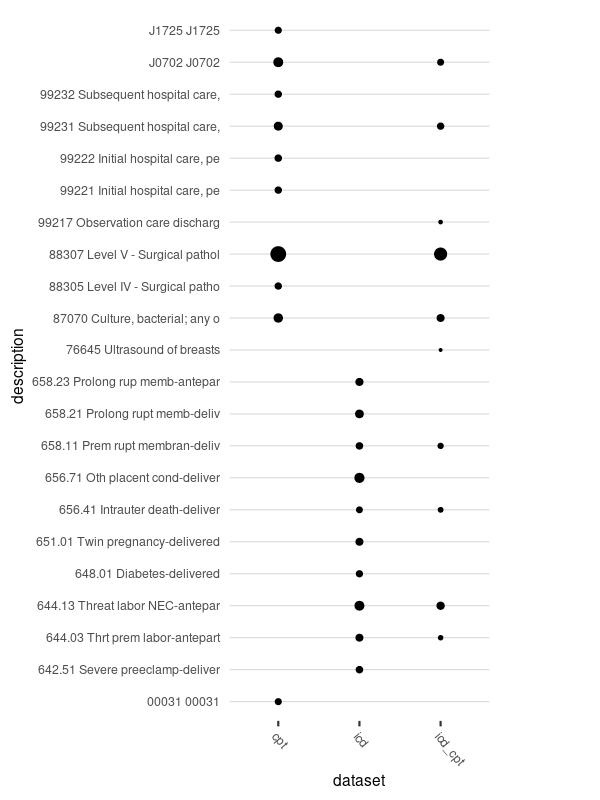

In [77]:
%%R -i feature_df   -h 800 -w 600 -r 80

library("ggplot2")
p <- ggplot(data = feature_df, aes(y = description, 
                                   x=dataset,  size=importance))
p <- p + geom_point() + scale_shape_manual(values=c(0, 4)) 
p <- p + theme_bw(base_size = 20)  + theme(text = element_text(size=14), 
                                           axis.text.x = element_text(angle=310, hjust=0),
#                                            axis.text.y = element_text(colour = "gray"),
                                           legend.position=c(1.2,0.9),
                                           plot.margin = margin(10, 100, 10, 10)) 
# p = p + facet_grid(~dataset)
p + scale_color_brewer(palette="Paired") + guides(color = FALSE, size=FALSE)+ theme(panel.grid.minor.x=element_blank(),
           panel.grid.major.x=element_blank(),  axis.ticks.y=element_blank(), 
           panel.grid.major.y=element_line(color='lightgray', size=0.4) , panel.border = element_blank())

# Feature Importance Using SHAP values

In [17]:
import shap
from textwrap import wrap

In [18]:
# load descriptions dictionary 
dsc_dict = create_descrip_dictionary(ICD_CPT_DESCRIP_FILE)

In [20]:
STORED_SHAP_FILE = os.path.join(OUTPUT_DIR, '{}_shapley_icd_cpt_dicts.pickle'.format(DATE))

In [ ]:
if os.path.isfile(STORED_SHAP_FILE):
    shap_file = open(STORED_SHAP_FILE, 'rb')
    dataset_dict = pickle.load(shap_file)
    print("loaded shap dict")
else: 
    print("creating shap dict")
    # calc  shapley value for each dataset
    shap_dict = {} 
    for this_label in dataset_dict.keys():

        this_input_df = dataset_dict[this_label]['input_df']
        this_model = dataset_dict[this_label]['xgb_model']
        X_train, y_train, X_test, y_test = get_train_test_arrays(this_input_df)

        # create train and test df 
        train_df = this_input_df.loc[this_input_df['partition']=='grid_cv'].copy()
        train_df.drop(['GRID','label','partition'], axis=1, inplace=True)


        # shap values 
        explainer = shap.TreeExplainer(this_model)
        shap_values = explainer.shap_values(train_df)

        shap_dict[this_label] = {'shapley': shap_values, 'train_data': train_df}
    pickle.dump(shap_dict, open(STORED_SHAP_FILE, 'wb'))

In [36]:
feat_output_dir = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/counts_icd_cpt/feature_importance"

In [138]:
shapley = shap_dict['icd_cpt']['shapley']
tdata = shap_dict['icd_cpt']['shapley']

In [139]:
filter_shap(shapley)

,36415-Collection of venous blood by venipuncture,"90715-Tetanus, diphtheria toxoids and acellular pertussis vaccine (Tdap), when administered to individuals 7 years or older, for intramuscular use","76820-Doppler velocimetry, fetal; umbilical artery","99232-Subsequent hospital care, per day, for the evaluation and management of a patient, which requires at least 2 of these 3 key components: An expanded problem focused interval history; An expanded problem focused examination; Medical decision making of moder",V22.1-Supervis oth normal preg,V27.0-Deliver-single liveborn,J0702-J0702,789.00-Abdmnal pain unspcf site,"85025-Blood count; complete (CBC), automated (Hgb, Hct, RBC, WBC and platelet count) and automated differential WBC count",278.00-Obesity NOS,V02.51-Group b streptoc carrier,"99213-Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: An expanded problem focused history; An expanded problem focused examination; Medical decision making of low",656.81-Fet/plac prob NEC-deliv,"99202-Office or other outpatient visit for the evaluation and management of a new patient, which requires these 3 key components: An expanded problem focused history; An expanded problem focused examination; Straightforward medical decision making. Counseling a",656.51-Poor fetal growth-deliv
0,1.095285e+06,-5.639228e+05,6.483811e+05,-3.849734e+05,-5.155860e+05,-4.662162e+05,-3.974945e+05,-1.373585e+05,8.493751e+05,-1.115294e+06,-1.123863e+06,-3.633399e+05,-3.507162e+05,-3.564574e+05,-3.142886e+05
1,-2.386108e+06,-2.861852e+06,6.445994e+05,8.105800e+05,3.464640e+05,3.670999e+05,6.644331e+05,8.615711e+05,-2.819744e+06,5.245877e+05,3.357504e+05,6.926277e+05,8.199871e+05,8.475412e+05,8.469226e+05
2,-1.755524e+02,4.124286e+01,1.748362e+02,-5.411083e+00,-1.118280e+02,-1.354994e-01,-7.796678e+01,5.210717e+00,-1.735946e+01,8.604323e+01,8.681310e+02,1.222172e+00,1.751155e+01,2.265166e-01,-6.819987e+01
3,-1.316282e+04,-3.972212e+04,-3.500874e+03,-2.951869e+03,-9.207373e+04,-1.108997e+05,1.130152e+03,1.814187e+04,-3.006698e+04,4.694913e+02,-4.396178e+02,-1.130008e+05,6.651718e+03,5.960328e+03,4.166032e+03
4,-2.289870e+05,1.354346e+04,-7.334165e+04,-6.405754e+04,3.379387e+04,-2.427078e+05,-2.428130e+05,-2.956773e+04,-7.433364e+04,2.087011e+04,-1.862978e+02,-7.069748e+04,-5.252890e+04,-5.498600e+04,-5.901916e+04
5,2.008452e+05,1.112410e+05,2.378951e+05,3.372897e+05,3.324931e+05,2.230912e+05,3.125941e+05,3.229782e+05,1.009514e+05,3.508067e+05,2.195696e+05,3.227694e+05,4.044869e+05,3.774519e+05,4.475148e+05
6,-7.005632e+05,-2.824403e+05,-3.629057e+05,-4.319838e+05,-3.580591e+05,-1.368447e+05,-4.215791e+05,-5.394046e+05,-1.507858e+05,-2.321409e+05,-1.181351e+05,-4.430507e+05,-4.727826e+05,-4.516606e+05,-4.666080e+05
7,-5.382744e+03,-5.923944e+03,-9.873911e+03,-8.735717e+03,-5.666932e+03,-5.508868e+03,-8.707977e+03,-8.813323e+03,-1.481123e+04,-1.239316e+04,-1.258207e+04,-1.524560e+04,-5.386796e+03,-5.510971e+03,-9.185211e+03
8,3.262755e+05,6.003458e+03,2.596622e+05,2.879071e+05,-4.508773e+05,4.422572e+05,2.573328e+05,2.913027e+05,3.060674e+04,3.747754e+05,3.505945e+05,1.717738e+05,2.692090e+05,2.574396e+05,2.700119e+05
9,1.932671e+03,-8.308192e+02,3.264776e+03,4.111154e+03,1.684308e+03,2.573838e+03,4.110634e+03,4.934589e+03,5.327556e+02,6.301191e+03,-1.674783e+04,-3.958091e+02,4.760490e+03,-4.106190e+02,5.227720e+03


In [93]:
def filter_shap(shapley_array):
#     short_col = [x.split("-")[0] for x in items['train_data'].columns]
    to_plot = pd.DataFrame(shapley_array, columns=['\n'.join(wrap(l, 100)) for l in items['train_data'].columns] )
    
    sum_df = to_plot.sum(0).reset_index().rename(columns={'index':'feature', 0:'shap_val'})
    sum_df['abs_shap_val'] = sum_df.shap_val.abs()
    sum_df['mean_abs_shap_val'] = sum_df.shap_val.abs()/sum_df.shape[1]
    
    keep_col = sum_df.sort_values('abs_shap_val', ascending=False).iloc[:15,0].values
    
    
    
    return to_plot.loc[:, keep_col]

In [94]:
to_plot = filter_shap(shp)

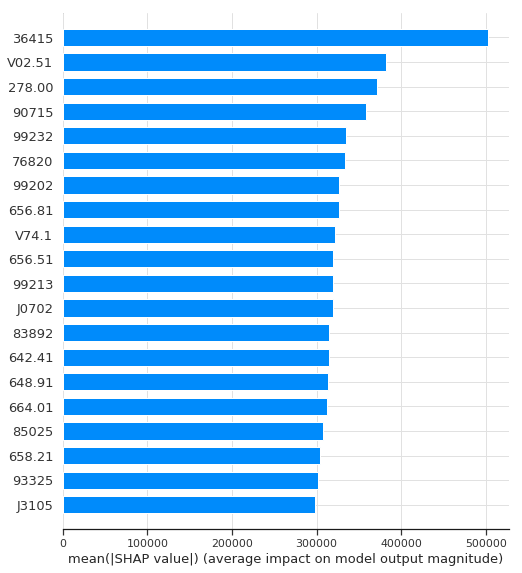

In [137]:
shap.summary_plot(items['shapley'], items['train_data'], plot_type='bar',  
                  feature_names=[ l.split("-")[0] for l in items['train_data'].columns], show=False)

In [39]:
## violin dot plot 
for key, items in shap_dict.items(): 
    print(key)
    shap.summary_plot(items['shapley'], items['train_data'], show=False)
    plt.tight_layout()
    _ = plt.title(key)
    _ = plt.savefig(os.path.join(output_dir,'{}_violin_shap_{}.pdf'.format(key, DATE)),  orientation='landscape')
    plt.clf()

icd
cpt


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


icd_cpt


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


<Figure size 576x684 with 0 Axes>

In [ ]:
shap.summary_plot(shap_values, train_df, plot_type="bar")

In [21]:
# load data 
this_label = 'icd'
this_input_df = dataset_dict[this_label]['input_df']
this_model = dataset_dict[this_label]['xgb_model']
X_train, y_train, X_test, y_test = get_train_test_arrays(this_input_df)

In [22]:
train_df = this_input_df.loc[this_input_df['partition']=='grid_cv'].copy()
held_out_df = this_input_df.loc[this_input_df['partition']=='held_out'].copy()

train_df.drop(['GRID','label','partition'], axis=1, inplace=True)
held_out_df.drop(['GRID','label','partition'], axis=1, inplace=True)

In [23]:
# convert col to descriptions 
train_df.columns = train_df.columns.map(dsc_dict)

In [24]:
explainer = shap.TreeExplainer(this_model)

In [26]:
shap_values = explainer.shap_values(train_df)

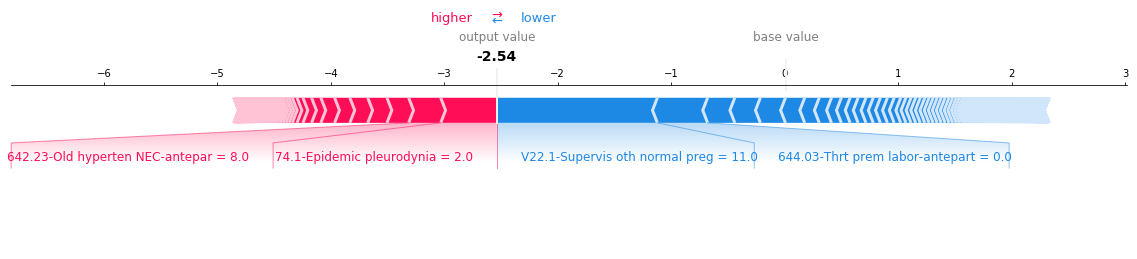

In [29]:
shap.force_plot(explainer.expected_value, shap_values[23,:], train_df.iloc[23,:], matplotlib=True)
# shap.force_plot(explainer.expected_value, shap_values[1,:], in_df.iloc[1,:], matplotlib=True)

In [28]:
shap.dependence_plot("644.03", shap_values, in_df)

NameError: name 'in_df' is not defined

In [ ]:
shap.summary_plot(shap_values, in_df)

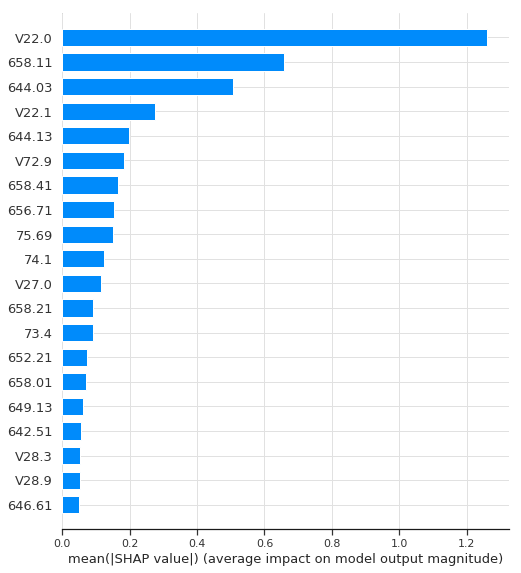

In [88]:
shap.summary_plot(shap_values, in_df.iloc[0:5,:], plot_type="bar")